In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spat

Warning: This does not work well for now.
    
    
    
Load the registration vectors

In [2]:
alls=np.load("./data/testingandys/wholerefmatches.npy",allow_pickle=True)

We have in total:

In [3]:
len(alls)

2708

Text(0.5, 0, 't slice')

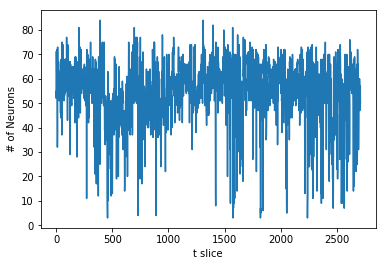

In [4]:
plt.plot([len(a) for a in alls])
plt.ylabel("# of Neurons")
plt.xlabel("t slice")

save first 200 frame's vectors in one array (800 in Andy's paper)

In [6]:
allvectors=[]
for fr in alls[:200]:
    allvectors.extend(fr)
allvectors=np.array(allvectors,dtype=int)+1

In [7]:
len(allvectors)

11775

defined the correlation distance of a classification vector

In [8]:
def corrdist(vec1,vec2):
    return 1-np.sum(((vec1-vec2)==0)&(vec1!=0))/200

query some random vectors to test

In [16]:
import time
mini=1
st=time.time()
for i in range(200):
    i1=np.random.randint(0,len(allvectors))
    i2=np.random.randint(0,len(allvectors))
    a=corrdist(allvectors[i1],allvectors[i2])
    if a<mini:
        mini=a
        ha=(i1,i2)
print("Smallest:",mini,"Inds:",ha,"Time:",time.time()-st)

Smallest: 0.63 Inds: (215, 8804) Time: 0.006700992584228516


Apply for all vectors in the frist 200 frames $N^2$ complexity ($<N>=N_{ref}*<N_{neurons}>$)

In [24]:
dmat=np.zeros((len(allvectors),len(allvectors)))
for i,vec1 in enumerate(allvectors):
    print("\r vec",i," Progress:",(i+1)*100/len(allvectors),"%",end="")
    for j,vec2 in enumerate(allvectors):
        if i>=j:
            continue
        dmat[i,j]=corrdist(vec1,vec2)
        dmat[j,i]=dmat[i,j]

 vec 11774  Progress: 100.0 %0743099787 % Progress: 0.9341825902335457 % Progress: 2.21656050955414 % %21.825902335456476 % 24.144373673036092 % 26.02123142250531 %% 3283  Progress: 27.8895966029724 % % 5849  Progress: 49.681528662420384 %% 6148  Progress: 52.2208067940552 % 6306  Progress: 53.56263269639066 % 6385  Progress: 54.23354564755839 % 6803  Progress: 57.78343949044586 % 6819  Progress: 57.91932059447983 % 6823  Progress: 57.953290870488324 % 7179  Progress: 60.97664543524416 % 7212  Progress: 61.25690021231423 % 7255  Progress: 61.62208067940552 % 7380  Progress: 62.683651804670916 % 7384  Progress: 62.717622080679405 % 7402  Progress: 62.87048832271762 %7411  Progress: 62.94692144373673 % 7437  Progress: 63.167728237791934 % 7473  Progress: 63.47346072186836 % 7569  Progress: 64.28874734607218 % 7728  Progress: 65.63906581740977 %7827  Progress: 66.47983014861995 % 8080  Progress: 68.62845010615712 % 8085  Progress: 68.67091295116772 % 8159  Progress: 69.29936305732484 % 85

Save it

In [25]:
#np.save("./data/testingandys/dmatwith200.npy",dmat)

We can load a saved one

In [18]:
dmat=np.load("./data/testingandys/dmatwith200.npy")

imshow the correlation matrix.

We see the moving lines since each frame has been flattened so the horizontal separation seen here is the approximaated detected neuron number in one frame

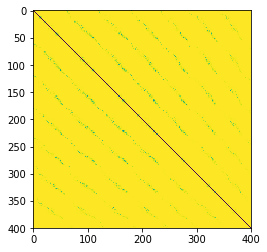

In [22]:
off=2000
plt.imshow(np.log(np.log(dmat[off:off+400,off:off+400]+1000)+1000).T)

Import clustering tools

In [24]:
import sklearn
import scipy.cluster.hierarchy as sch
import importlib
importlib.reload(sklearn)
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

Perform agglomerative Clustering

In [25]:
clustering = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage="complete",distance_threshold=0.999).fit(dmat)

Plot the dendogram

In [26]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

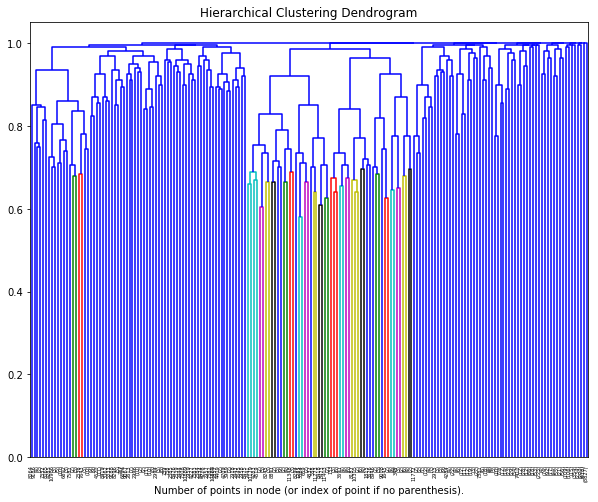

In [27]:
plt.figure(figsize=(10,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Make a label dictionary from the labels

In [30]:
res=clustering.labels_
labeldict={}
for i,re in enumerate(res):
    labeldict.setdefault(re,[]).append(i)
print("Total:",len(labeldict),"clusters.")

Total: 98 clusters.


In [31]:
ins={}
i=0
for scene,fr in enumerate(alls[:200]):
    for j,f in enumerate(fr):
        ins[i]=(scene,j)
        i+=1

Load some frames again

In [32]:
dats=np.load("./data/peaks/cleaned-test.npy",allow_pickle=True)

Randomly select a neuron

In [34]:
neu=list(labeldict.keys())[np.random.randint(0,len(labeldict.keys()))]
toplot=[]
for lab in labeldict[neu]:
    toplot.append(ins[lab])

Randomly select time frames where it is identified

Text(0.5, 1.0, 'Neuron76Total frames: 8')

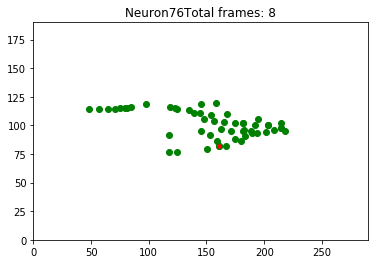

In [42]:
t,co=toplot[np.random.randint(0,len(toplot))]
plt.scatter(*dats[t][:,:2].T,c="green")
plt.scatter(*dats[t][co,:2].T,c="red",s=13)
plt.xlim(0,290)
plt.ylim(0,190)
plt.title("Neuron"+str(neu)+"Total frames: "+str(len(toplot)))

Doesn't work well for now